In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})

# import helper functions
from src.utls import compute_repeated_stats

In [2]:
# (import) helper functions
dir_proj = Path("__file__").absolute().parents[1]
dir_rawdata = Path.joinpath(dir_proj, "data")
dir_prep = Path.joinpath(dir_proj,"results")
print(dir_rawdata)


c:\Users\User\Desktop\kiel\tremor_music_ap\data


In [3]:
# load data
pd.read_csv(Path.joinpath(dir_prep,"single_subj_pow.csv"))
peaks = pd.read_csv(Path.joinpath(dir_prep,"single_subj_agg.csv"))
group_asgn = pd.read_excel(Path.joinpath(dir_rawdata,"group_assign.xlsx"), index_col=None)

In [4]:
# define cfg vars
cfg_srate = 100
cfg_group = {1:"Standard & exp. music", 2:"Standard & unspecific music", 3: "Only Standard", 4: "Placebo"}
cfg_trial = {1: "Standing flexed", 2:"Sitting", 3: "Sitting relaxed"}
cfg_visit = {1:"Inital", 2:"14-days"}

idx_axis_oi = peaks["axis"] == "y"
idx_task_oi = peaks["task"] == "Sitting flexed"
idx_visit_oi = peaks["visit"] != "Follow-up"
peaks.head()

,id,visit,task,axis,peak frequency,peak amplitude
0,BS0068,Inital,Standing flexed,x,5.865385,9544.121503
1,BS0068,Inital,Standing flexed,y,5.865385,373.978677
2,BS0068,Inital,Standing flexed,z,5.865385,162159.434519
3,BS0068,Inital,Sitting flexed,x,5.288462,3445.162849
4,BS0068,Inital,Sitting flexed,y,5.000000,450.935236


In [5]:
# assign group
group = pd.melt(group_asgn, value_name="id").dropna()
peaks_group = pd.merge(peaks, group, on="id", how="outer")

idx_visit_oi = peaks_group["visit"] != "Follow-up"
data_oi = peaks_group[idx_visit_oi]
data_oi = data_oi.groupby('id').filter(lambda x: {"Inital","14-days"}.issubset(x['visit']))
data_oi = data_oi.rename(columns={"variable": "group"})
sumed_axis = data_oi.groupby(['id','visit','group','task'],as_index=False)[["peak amplitude","peak frequency"]].sum()

n_rows = sumed_axis.shape[0]
sumed_axis["Norm amp"] = np.nan
sumed_axis["Norm freq"] = np.nan

for i in range(0,n_rows):
    idx_id = sumed_axis["id"].str.match(sumed_axis["id"][i])
    sumed_axis["Norm amp"][i] = sumed_axis["peak amplitude"][i] / np.nanmax(sumed_axis["peak amplitude"][idx_id])
    sumed_axis["Norm freq"][i] = sumed_axis["peak frequency"][i] / np.nanmax(sumed_axis["peak frequency"][idx_id])
    
sumed_axis.to_csv(Path.joinpath(dir_prep,"group_anova.csv"))

In [6]:
t_amp,p_amp, t_freq, p_freq = compute_repeated_stats(peaks,"Sitting relaxed")
print(f"Diff amp is {p_amp:.3f}; Diff freq is {p_freq:.3f};")

Diff amp is 0.039; Diff freq is 0.549;


## rmANOVA split for task

In [7]:
from statsmodels.stats.anova import AnovaRM

dat_sit_relx = sumed_axis[sumed_axis["task"] == "Sitting relaxed"]
dat_sit_relx = dat_sit_relx.append(dat_sit_relx[-6:-4],ignore_index=True)


In [8]:
#check if groups are balanced for statsmodel
dat_sit_relx.groupby(["visit","group"])["id"].count()

visit    group             
14-days  CONTROL GROUP 1       10
         CONTROL GROUP 2       10
         EXPERIMENTAL GROUP    10
         PLACEBO GROUP         10
Inital   CONTROL GROUP 1       10
         CONTROL GROUP 2       10
         EXPERIMENTAL GROUP    10
         PLACEBO GROUP         10
Name: id, dtype: int64

In [9]:
dat_sit_relx.head()

,id,visit,group,task,peak amplitude,peak frequency,Norm amp,Norm freq
0,BS0068,14-days,CONTROL GROUP 2,Sitting relaxed,60.405491,15.480769,0.000351,0.805000
1,BS0068,Inital,CONTROL GROUP 2,Sitting relaxed,121.524394,14.791667,0.000706,0.769167
2,BS0253,14-days,CONTROL GROUP 1,Sitting relaxed,10.855155,17.916667,0.001276,0.900161
3,BS0253,Inital,CONTROL GROUP 1,Sitting relaxed,39.026555,15.576923,0.004586,0.782609
4,BS0264,14-days,EXPERIMENTAL GROUP,Sitting relaxed,31.463395,19.230769,0.001389,0.916530


In [10]:
dat_rmanova = dat_sit_relx[["id","visit","Norm amp"]].copy()

aovrm1way = AnovaRM(dat_rmanova, 'Norm amp', 'id', within=['visit'], aggregate_func='mean')
res1way = aovrm1way.fit()

print(res1way)

n = dat_rmanova["id"].nunique()
print(f"A one-way repeated measures ANOVA was conducted on {n:2d} individuals to examine the effect of music therapy on tremor amplitude.")
print(f"Results showed that the treatment of therapy lead to statistically significant differences in tremor amplitude (F(1, {n-1:2d}) = 4.71, p = 0.036")

               Anova
      F Value Num DF  Den DF Pr > F
-----------------------------------
visit  4.7101 1.0000 38.0000 0.0363

A one-way repeated measures ANOVA was conducted on 39 individuals to examine the effect of music therapy on tremor amplitude.
Results showed that the treatment of therapy lead to statistically significant differences in tremor amplitude (F(1, 38) = 4.71, p = 0.036


### Check ANOVA assumptions

In [12]:
# Bartletts test for normal distribution

from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=dat_sit_relx, res_var='Norm amp', xfac_var='group')
res.bartlett_summary

,Parameter,Value
0,Test statistics (T),7.0707
1,Degrees of freedom (Df),3.0000
2,p value,0.0697


In [ ]:
from bioinfokit.analys import stat 
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='treatments')
res.levene_summary

In [ ]:
idx_group_exp = dat_sit_relx["group"] == "EXPERIMENTAL GROUP"
idx_group_c1 = dat_sit_relx["group"] == "CONTROL GROUP 1"
idx_group_c2 = dat_sit_relx["group"] == "CONTROL GROUP 2"
idx_group_pg = dat_sit_relx["group"] == "PLACEBO GROUP"

w, pvalue = stats.bartlett(dat_sit_relx["Norm amp"][idx_group_exp], 
                        dat_sit_relx["Norm amp"][idx_group_c1],
                        dat_sit_relx["Norm amp"][idx_group_c2],
                        dat_sit_relx["Norm amp"][idx_group_pg],)
                        
print(f"For the Bartletts test the p-value is {pvalue:.3f}")
print(f"As the p value is non significant, we conclude that data is drawn from normal distribution.")

For the Bartletts test the p-value is 0.070
As the p value is non significant, we conclude that data is drawn from normal distribution.


In [ ]:
# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the bartlett's test
from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=df_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary

<AxesSubplot:xlabel='group', ylabel='Norm amp'>

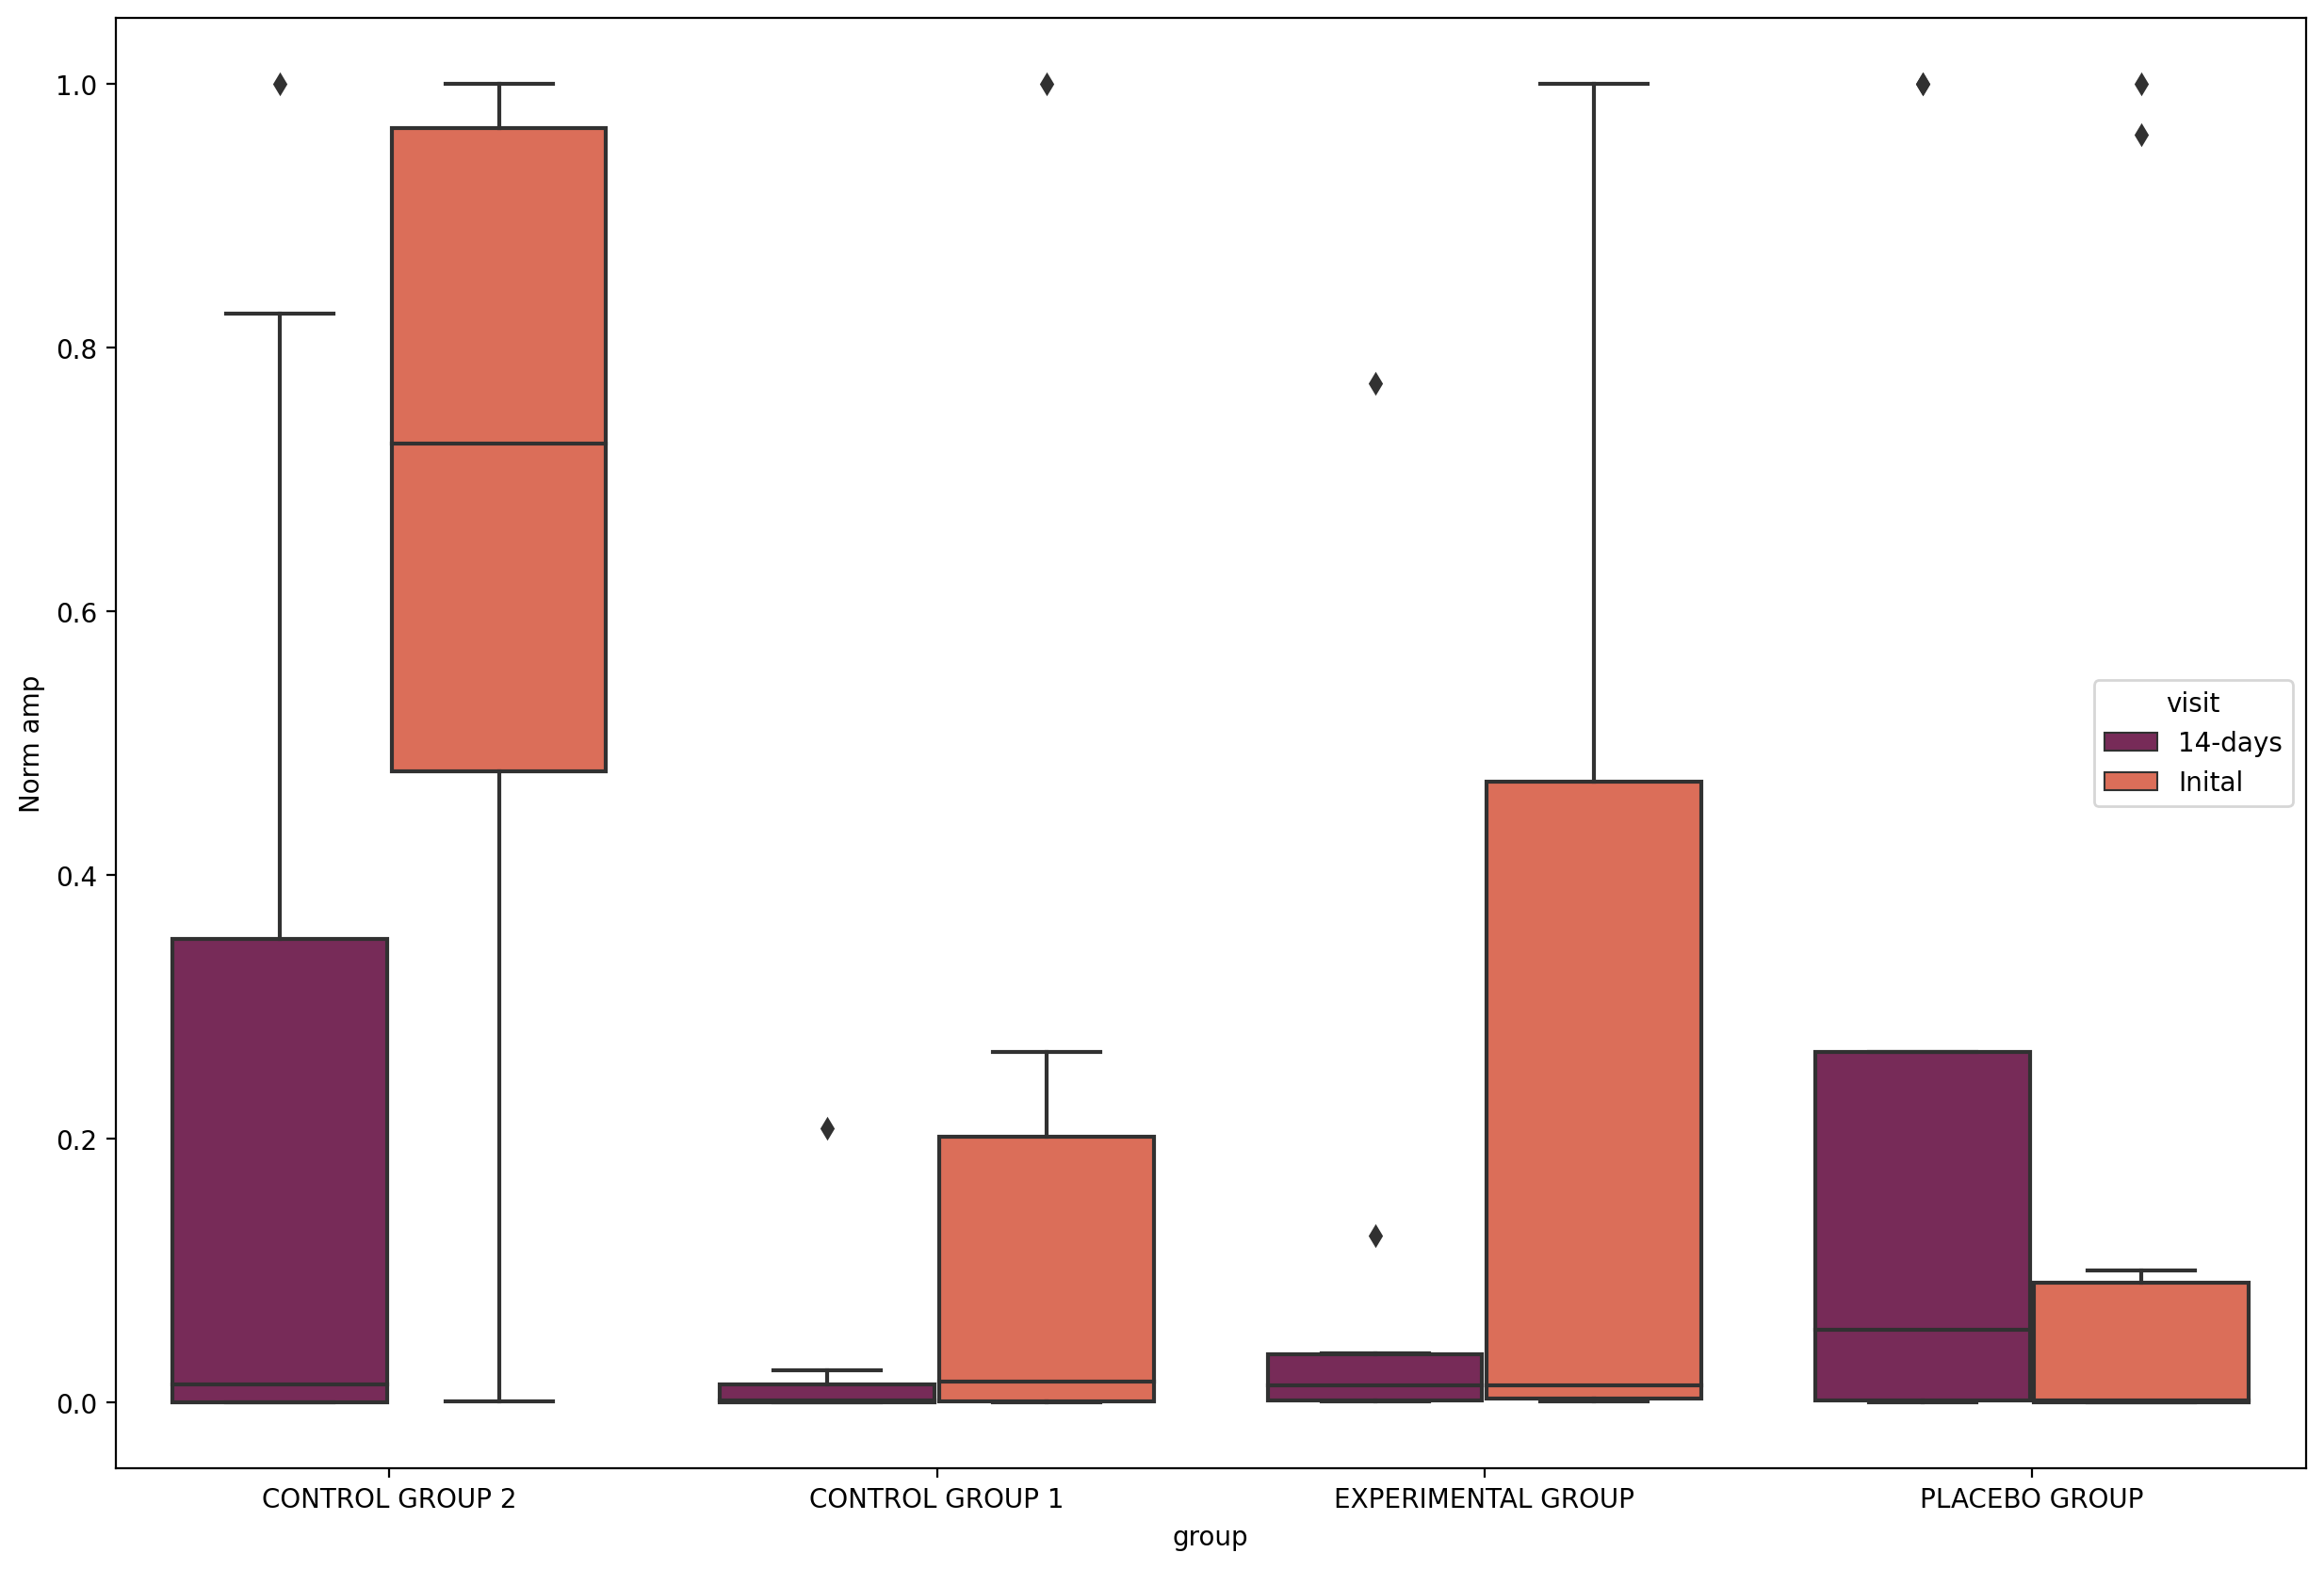

In [28]:
sns.boxplot(x="group", y="Norm amp", hue="visit", data=dat_sit_relx, palette="rocket") 

In [19]:
dat_rmanova = dat_sit_relx[["id","group","visit","Norm amp"]].copy()
dat_rmanova = dat_rmanova.rename(columns={"Norm amp": "amp"})

# rmANOVA table using bioinfokit v1.0.3 
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=dat_rmanova, res_var='amp', anova_model='amp~C(group)+C(visit)+C(group):C(visit)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(group),3.0,1.339058,0.446353,3.881252,0.012471
C(visit),1.0,0.504938,0.504938,4.390677,0.039653
C(group):C(visit),3.0,0.532566,0.177522,1.543638,0.210610
Residual,72.0,8.280163,0.115002,NaN,NaN


In [25]:
res = stat()
# for main effect Genotype
res.tukey_hsd(df=dat_rmanova, res_var='amp', xfac_var='visit', anova_model='amp~C(group)+C(visit)+C(group):C(visit)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,14-days,Inital,0.158893,0.007729,0.310056,2.963335,0.039652
